In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [2]:
# todo list in this cell
# explicitly write out forward and inverse transforms instead of velocity field
# specifics for 3D to 2D mapping
# apply transforms to new data from command line
# different data types: either preprocess data and convert format, or modify code to support another data type
# reading and writing in other data types: especially nifty nii, I would rely on nibabel to do this

In [3]:
atlas_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-mri-reorient.vtk'
#atlas_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-mri.nii.gz'
label_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-region_seg-reorient.vtk'
target_name = '/home/dtward/data/csh_data/marmoset/m1229/M1229MRI/MRI/exvivo/HR_T2/HR_T2_CM1229F-reorient.vtk'
config_file = 'config1229.json'
output_dir = '1229_test_outputs/'
output_image_format = '.nii'

In [4]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


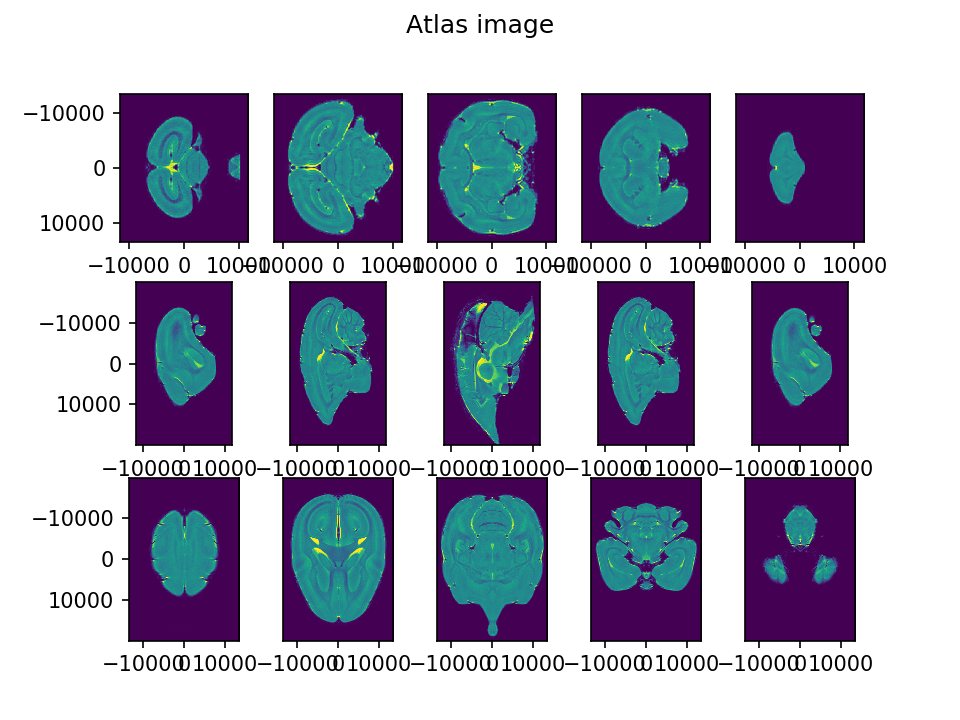

Text(0.5, 0.98, 'Atlas image')

In [5]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

In [6]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[159.99999599999865, 159.99999600000046, 224.00000600000203]


Found extension .vtk
[100.000001 100.000001 200.000003]


<IPython.core.display.Javascript object>


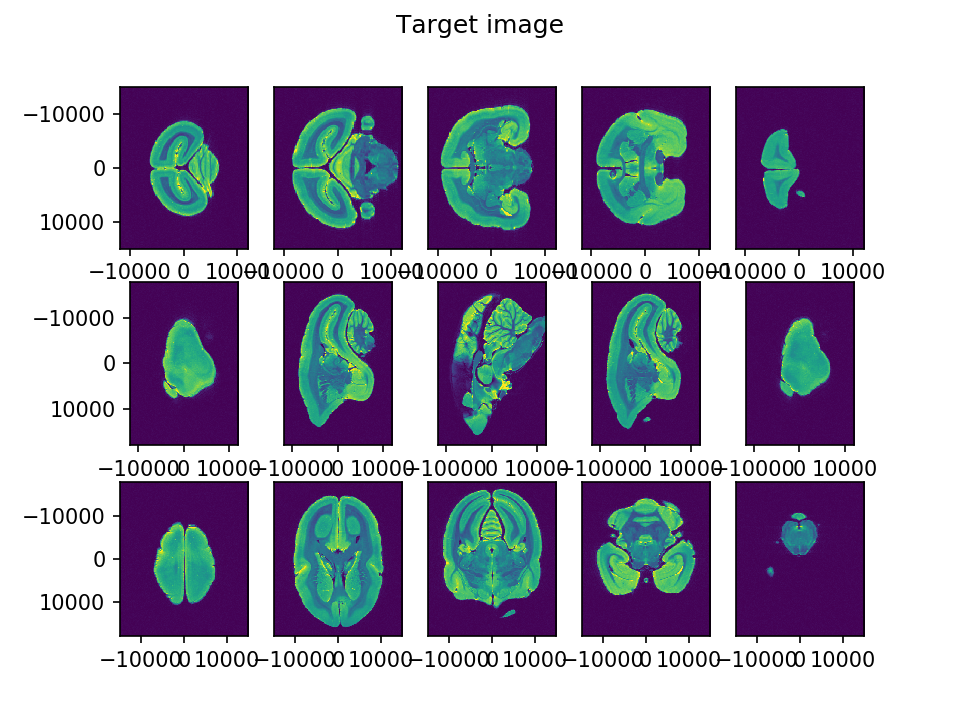

In [7]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
W0 = np.ones_like(J[0])

In [8]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

<IPython.core.display.Javascript object>


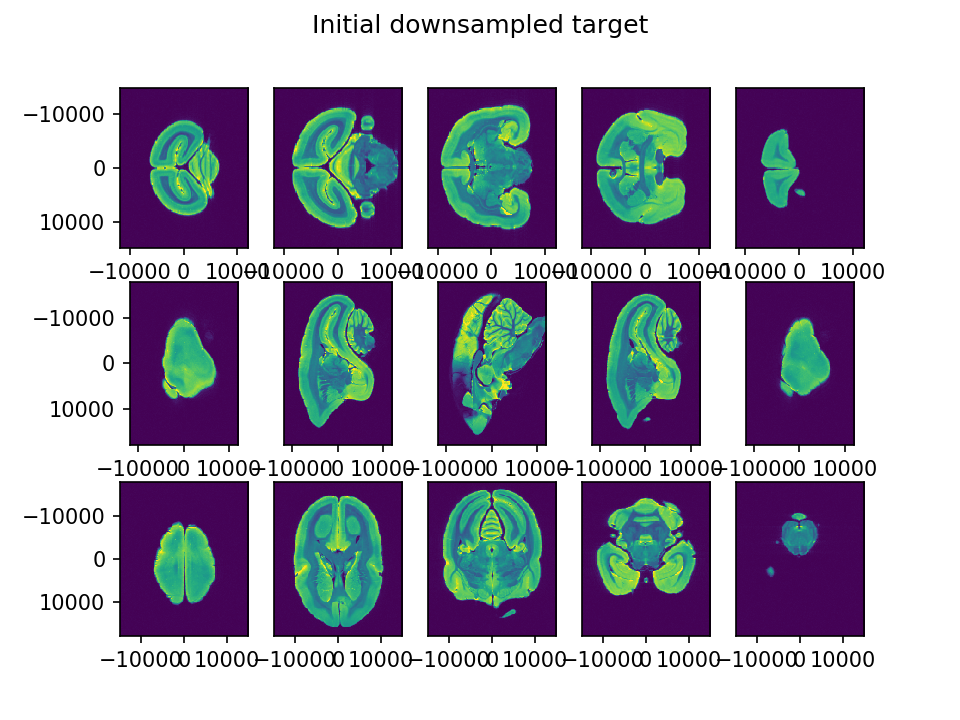

Text(0.5, 0.98, 'Initial downsampled target')

In [9]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')


<IPython.core.display.Javascript object>


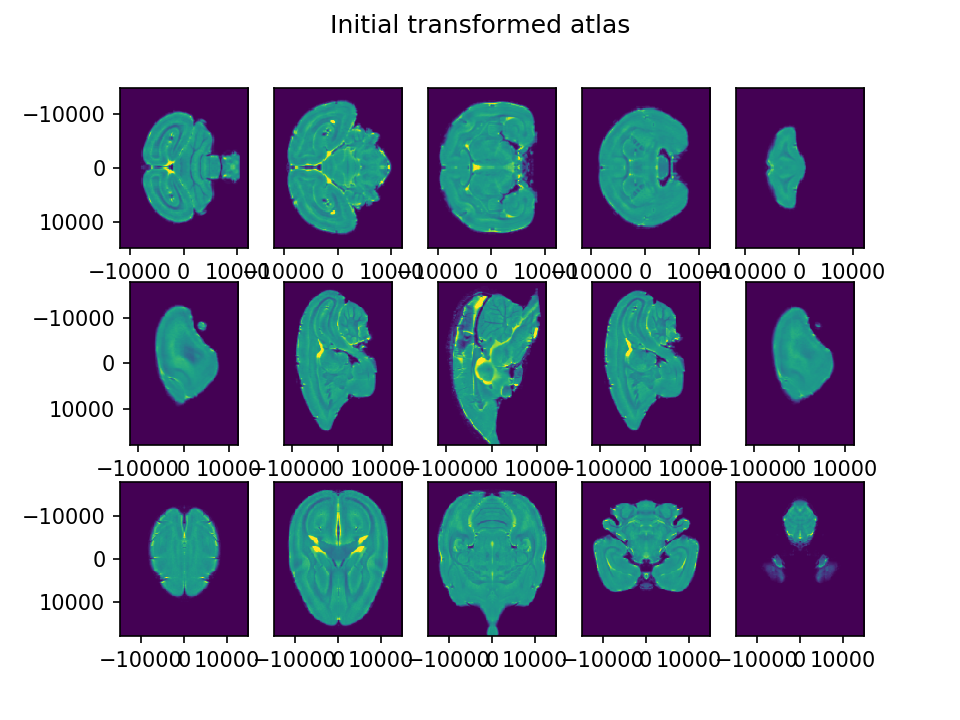

Text(0.5, 0.98, 'Initial transformed atlas')

In [10]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

Found 2 scales
dv tensor([480., 480., 672.], device='cuda:0')
a scale is 960.0


<IPython.core.display.Javascript object>


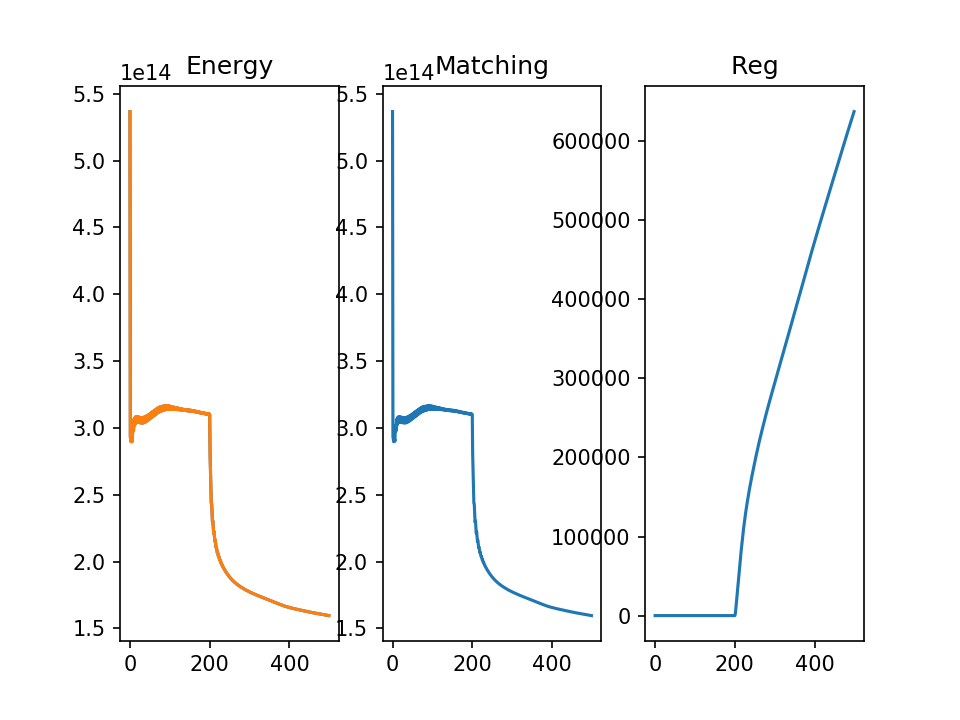

<IPython.core.display.Javascript object>


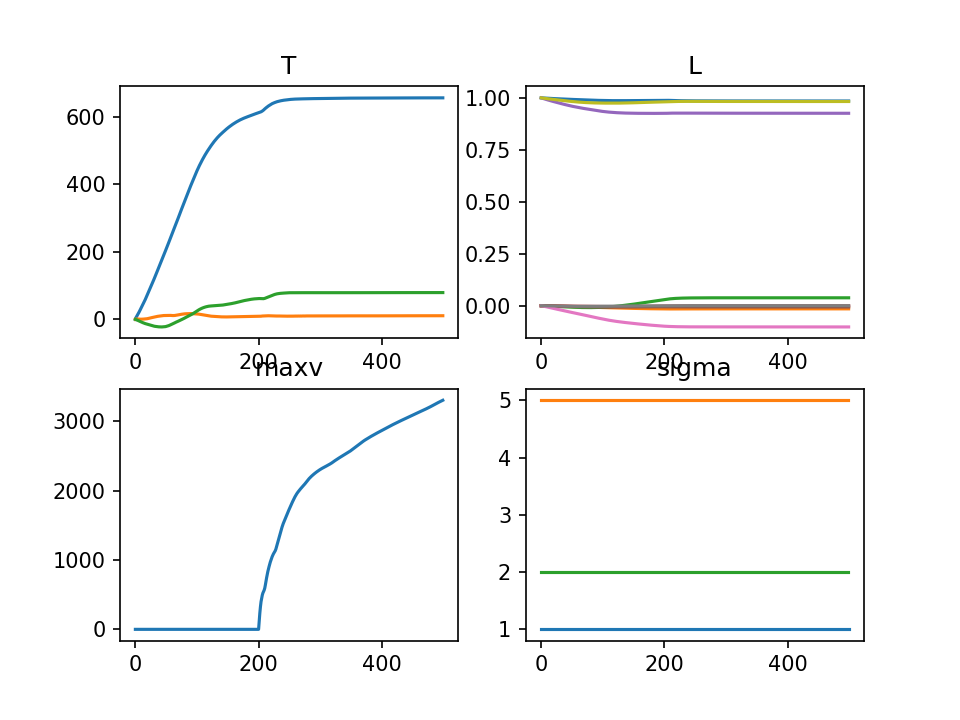

<IPython.core.display.Javascript object>


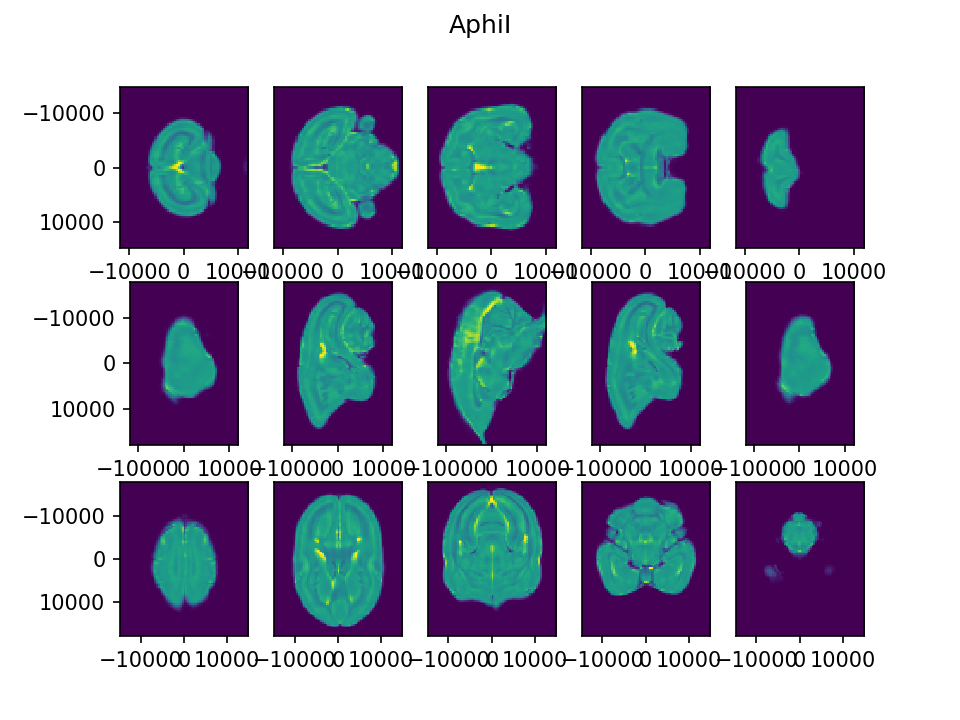

<IPython.core.display.Javascript object>


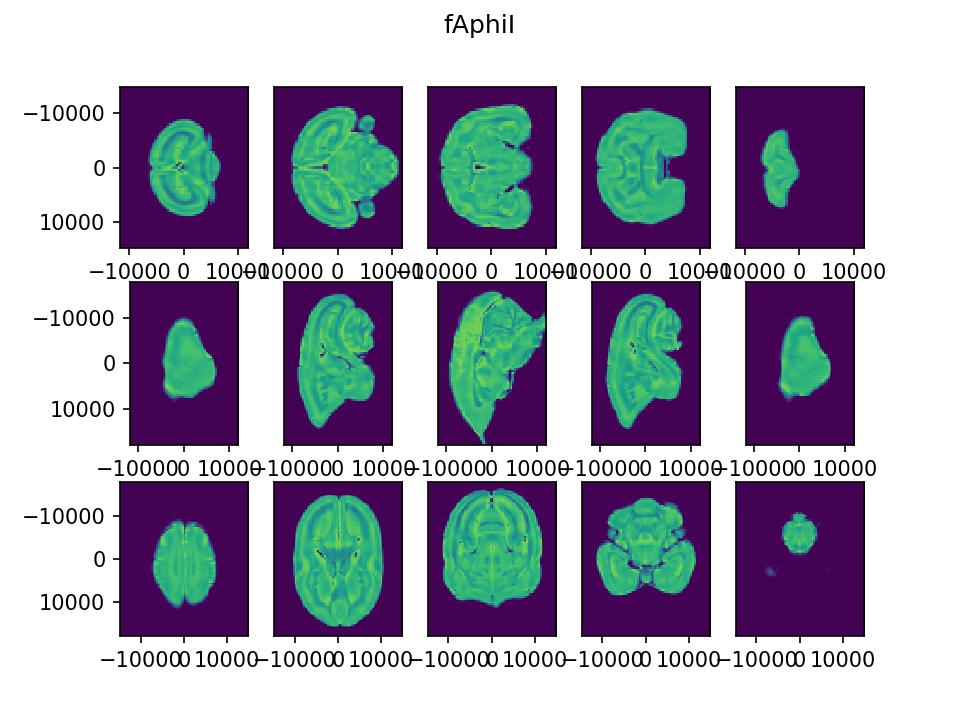

<IPython.core.display.Javascript object>


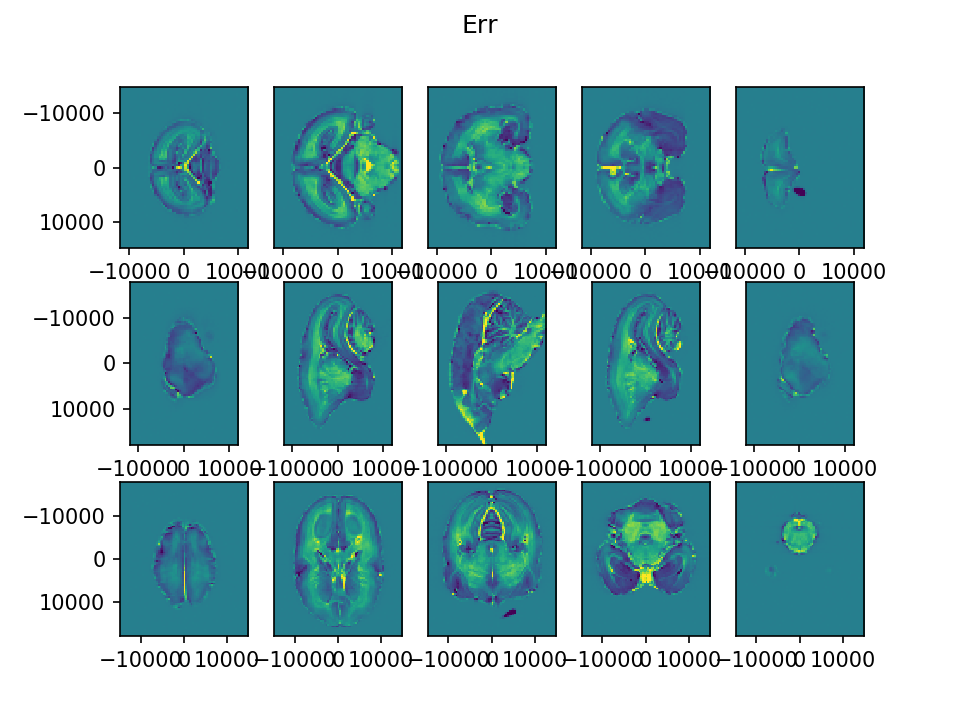

<IPython.core.display.Javascript object>


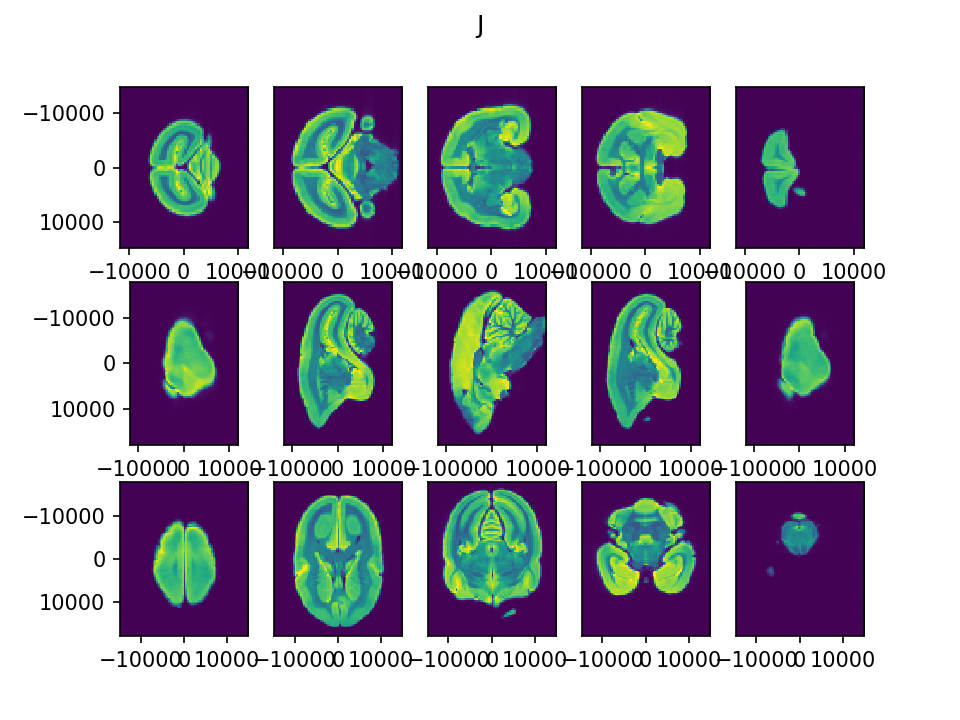

<IPython.core.display.Javascript object>


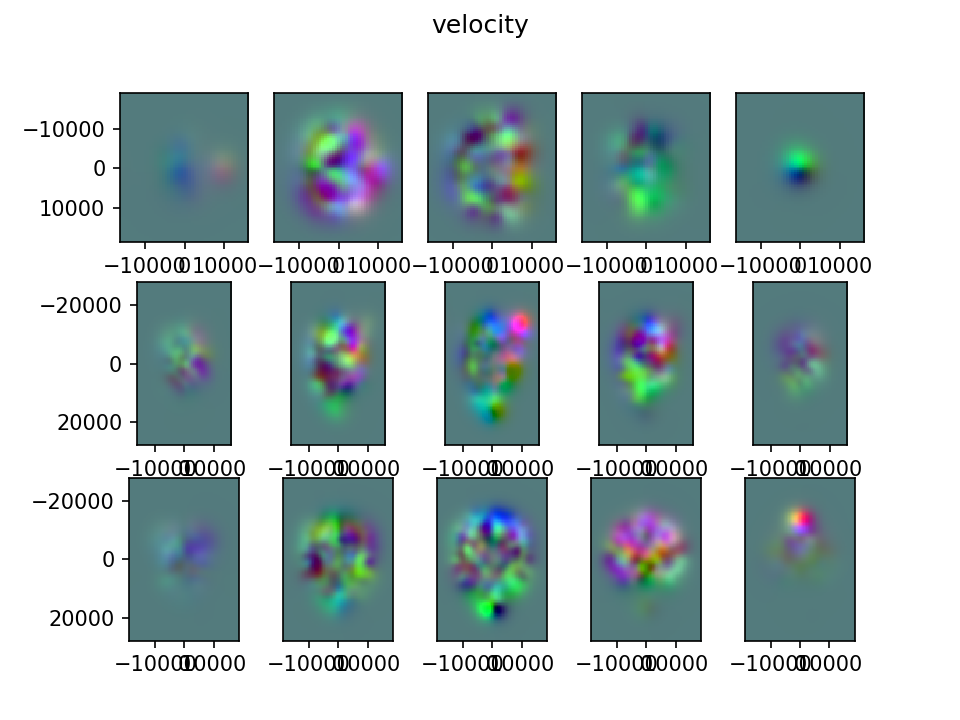

<IPython.core.display.Javascript object>


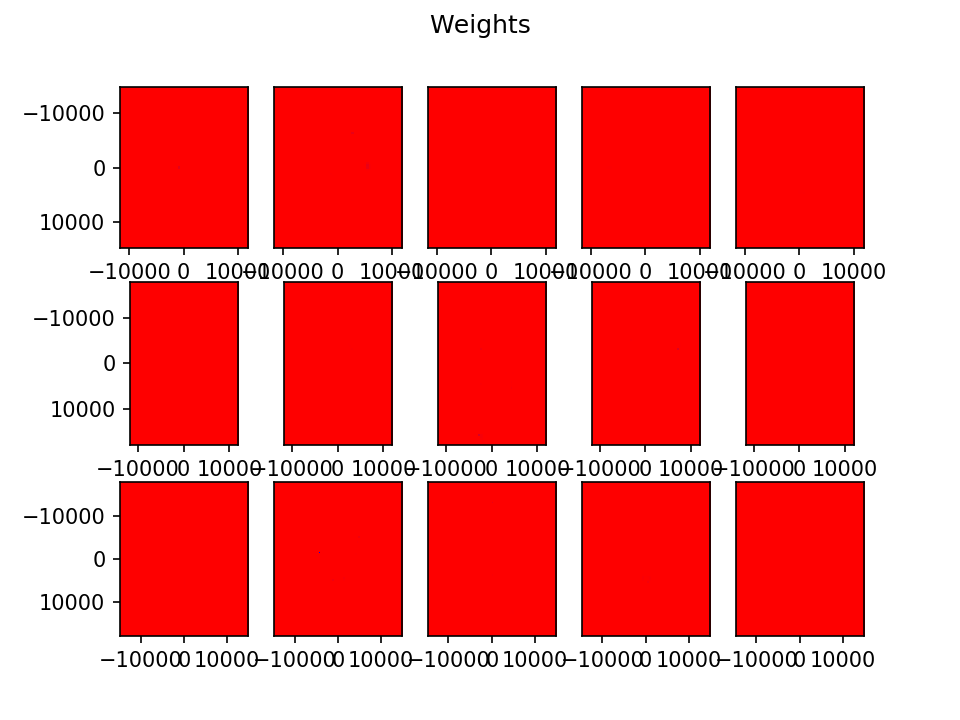

/mnt/data/csh_data/emlddmm/emlddmm.py:45: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Finished iteration 210
Finished iteration 220
Iteration 230, translation oscilating, reducing eA to 90000.0
Finished iteration 230
Iteration 240, translation oscilating, reducing eA to 81000.0
Finished iteration 240
Iteration 250, translation oscilating, reducing eA to 72900.0
Finished iteration 250
Iteration 260, translation oscilating, reducing eA to 65610.0
Finished iteration 260
Iteration 270, translation oscilating, reducing eA to 59049.0
Finished iteration 270
Iteration 280, translation oscilating, reducing eA to 531

<IPython.core.display.Javascript object>


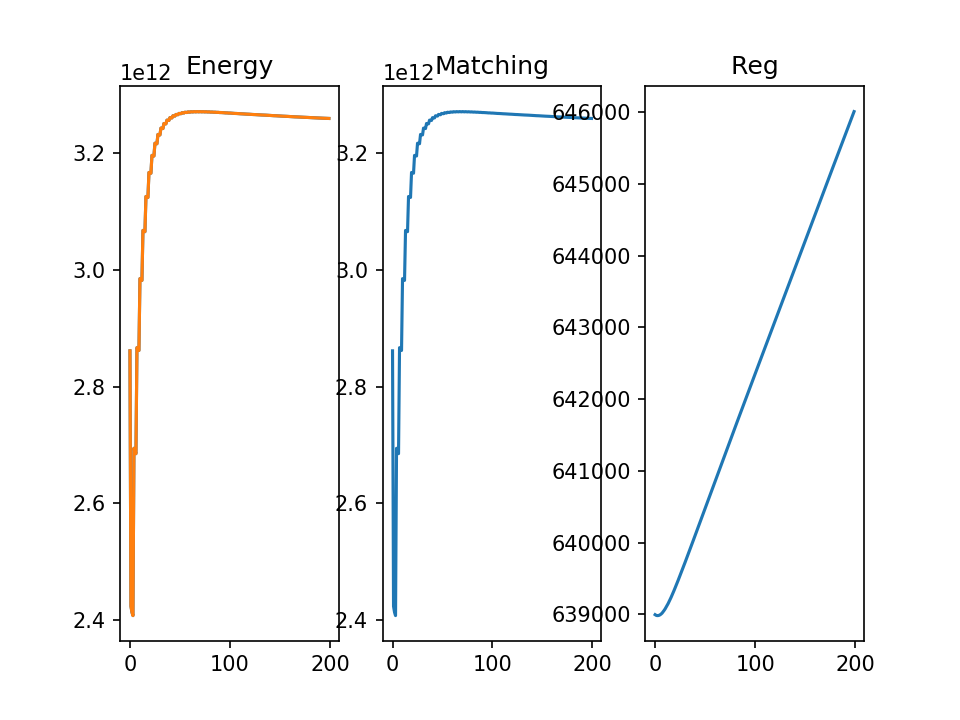

<IPython.core.display.Javascript object>


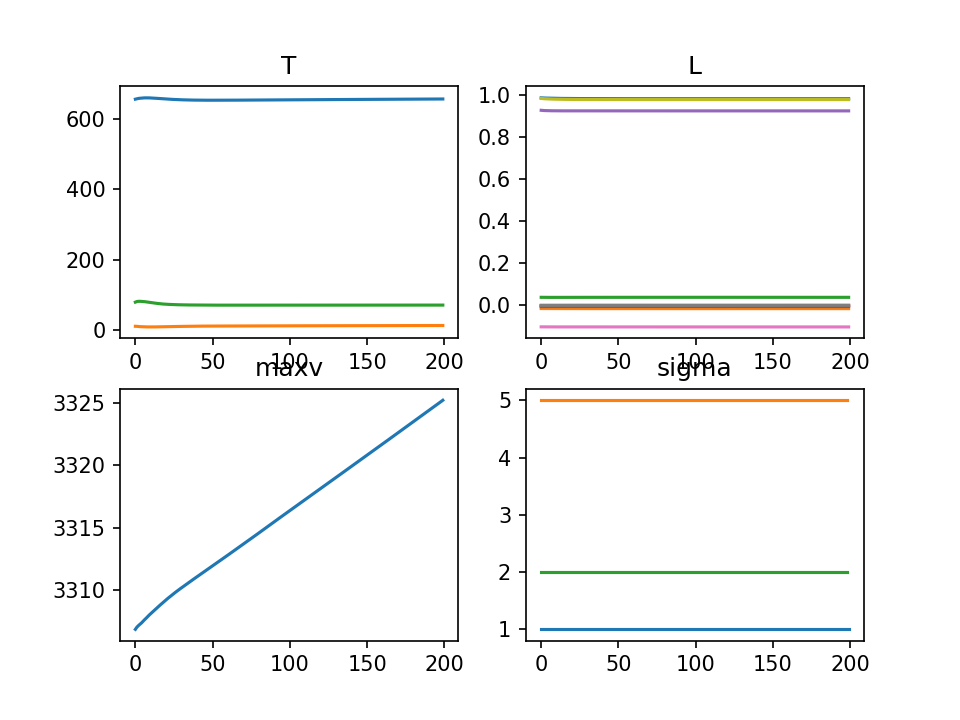

<IPython.core.display.Javascript object>


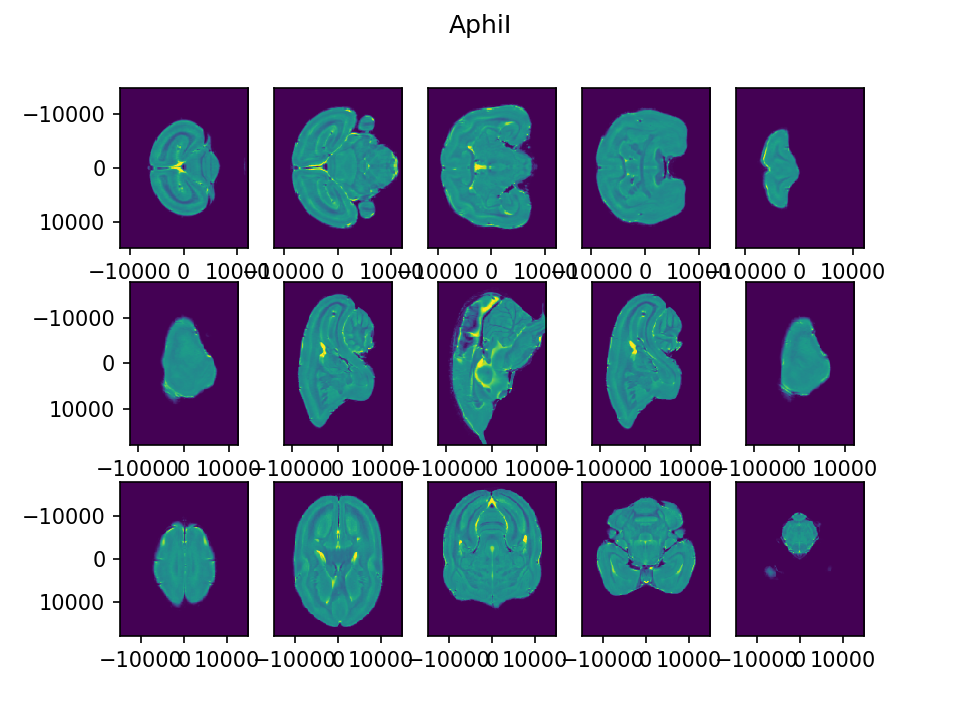

<IPython.core.display.Javascript object>


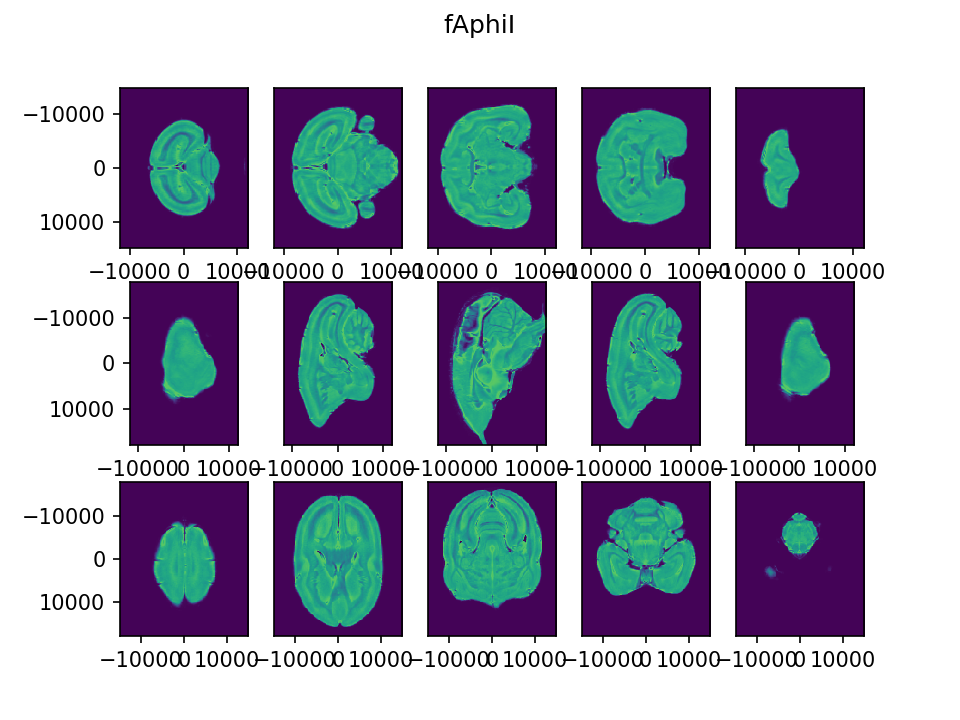

<IPython.core.display.Javascript object>


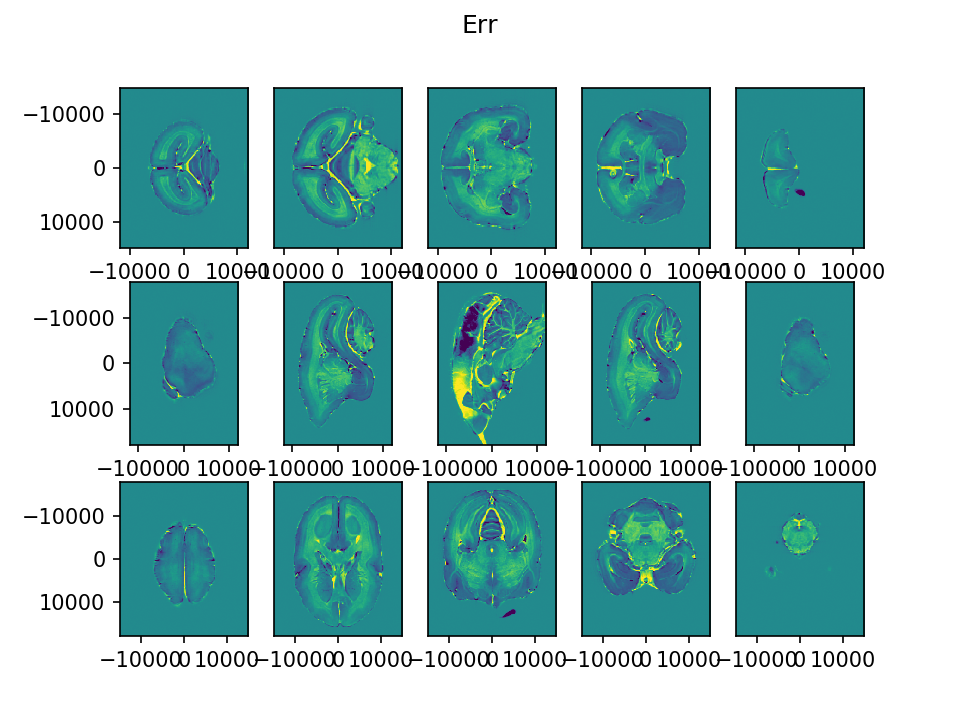

<IPython.core.display.Javascript object>


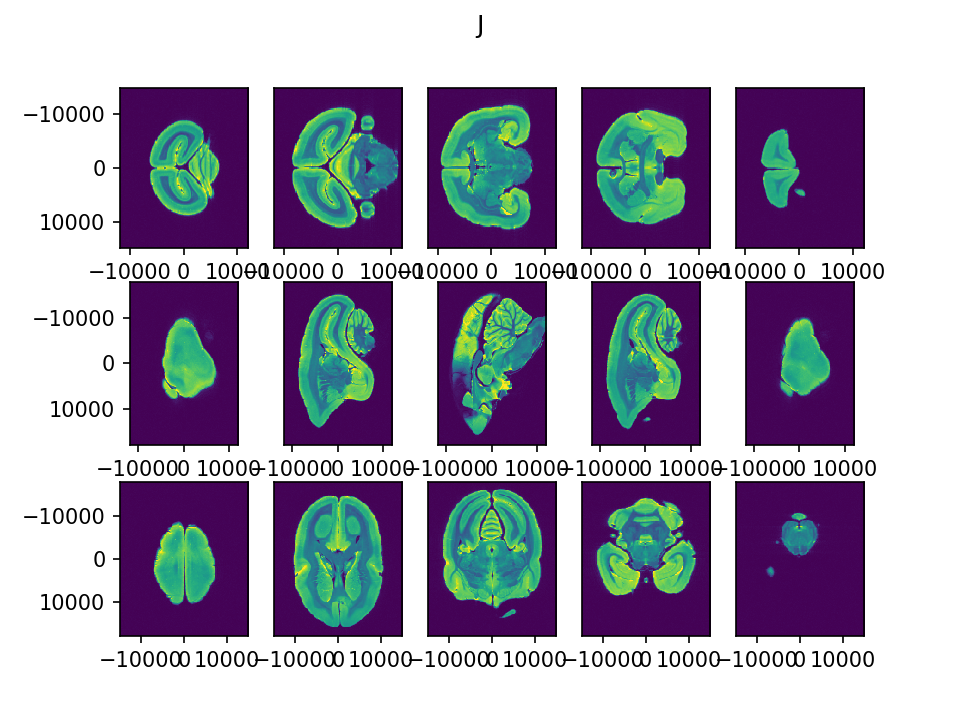

<IPython.core.display.Javascript object>


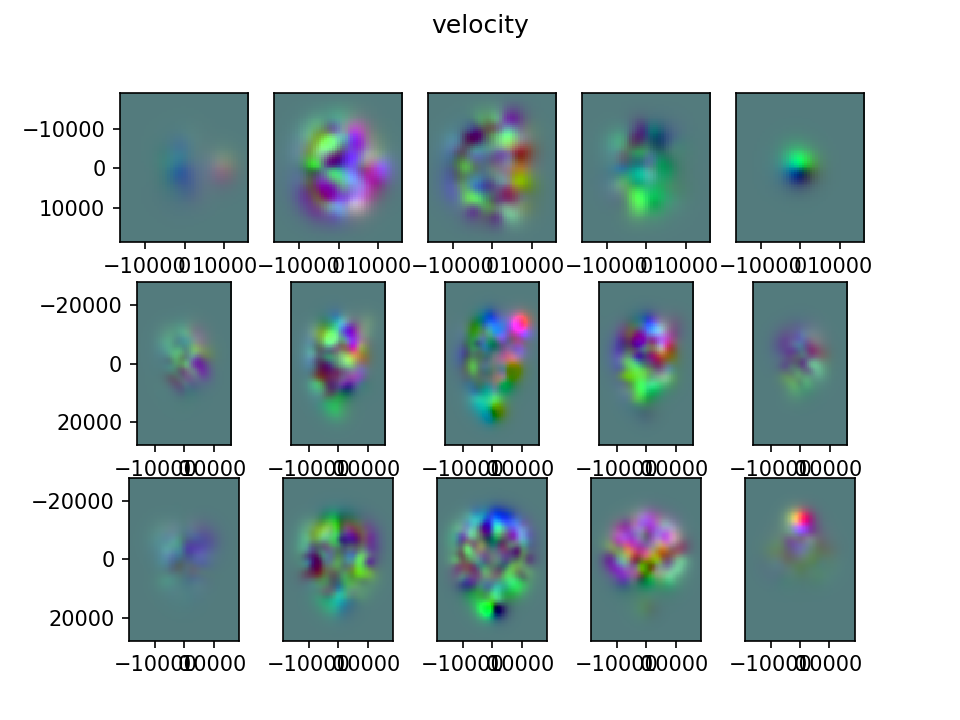

<IPython.core.display.Javascript object>


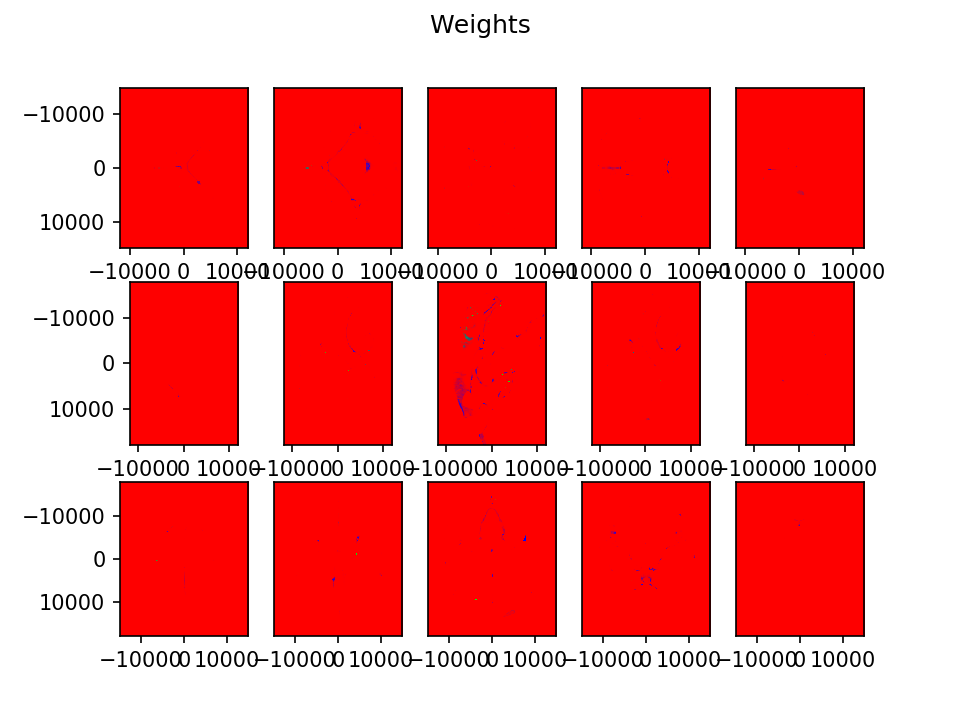

Finished iteration 0
Finished iteration 10
Iteration 20, linear oscilating, reducing eA to 90000.0
Finished iteration 20
Finished iteration 30
Finished iteration 40
Iteration 50, linear oscilating, reducing eA to 81000.0
Finished iteration 50
Iteration 60, linear oscilating, reducing eA to 72900.0
Finished iteration 60
Iteration 70, linear oscilating, reducing eA to 65610.0
Finished iteration 70
Iteration 80, linear oscilating, reducing eA to 59049.0
Finished iteration 80
Iteration 90, linear oscilating, reducing eA to 53144.1
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Iteration 140, translation oscilating, reducing eA to 47829.69
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190


In [11]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [52]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [53]:
# get labels
xS,S,title,names = emlddmm.read_data(label_name,endian='l')

Found extension .vtk


cpu
output dir is 1229_test_outputs/qc/


/mnt/data/csh_data/emlddmm/emlddmm.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


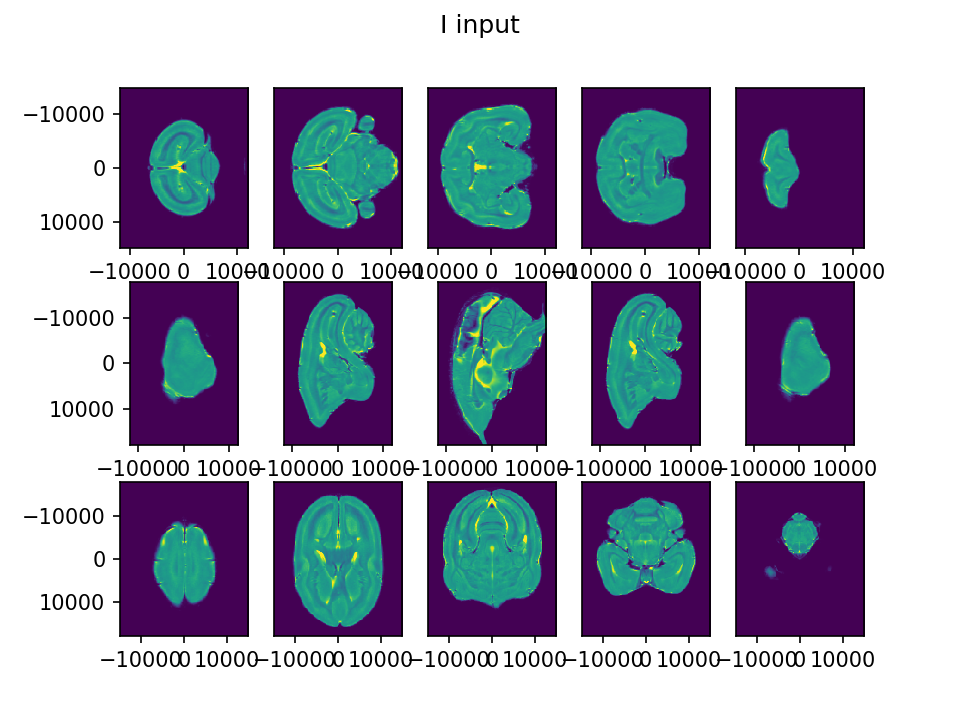

<IPython.core.display.Javascript object>


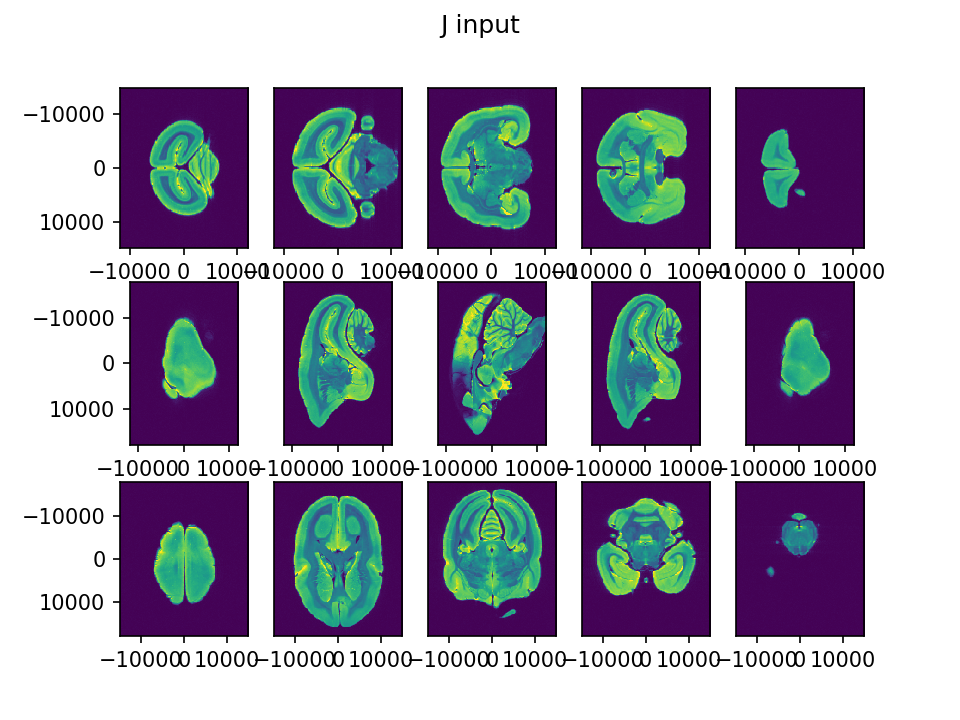

<IPython.core.display.Javascript object>


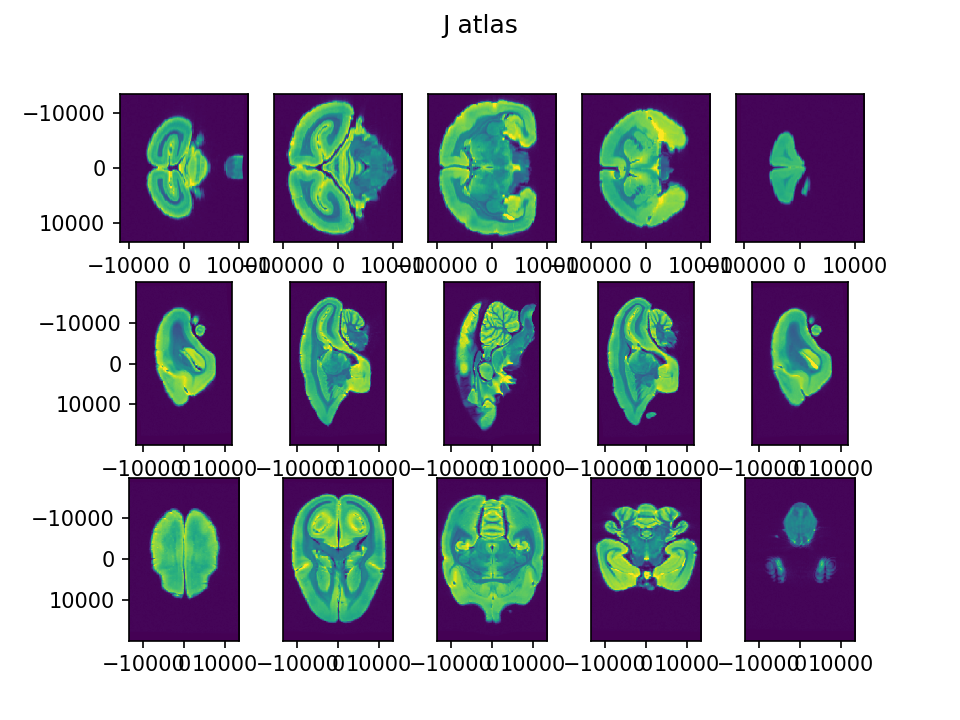

<IPython.core.display.Javascript object>


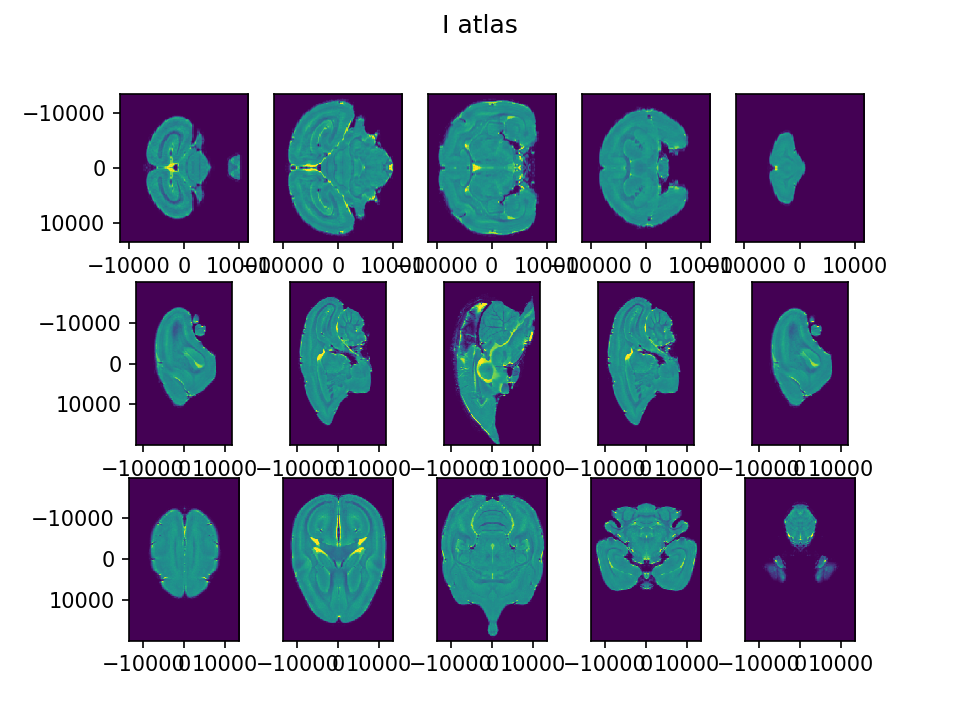

In [54]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [63]:
# test it, forward transform
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

<IPython.core.display.Javascript object>


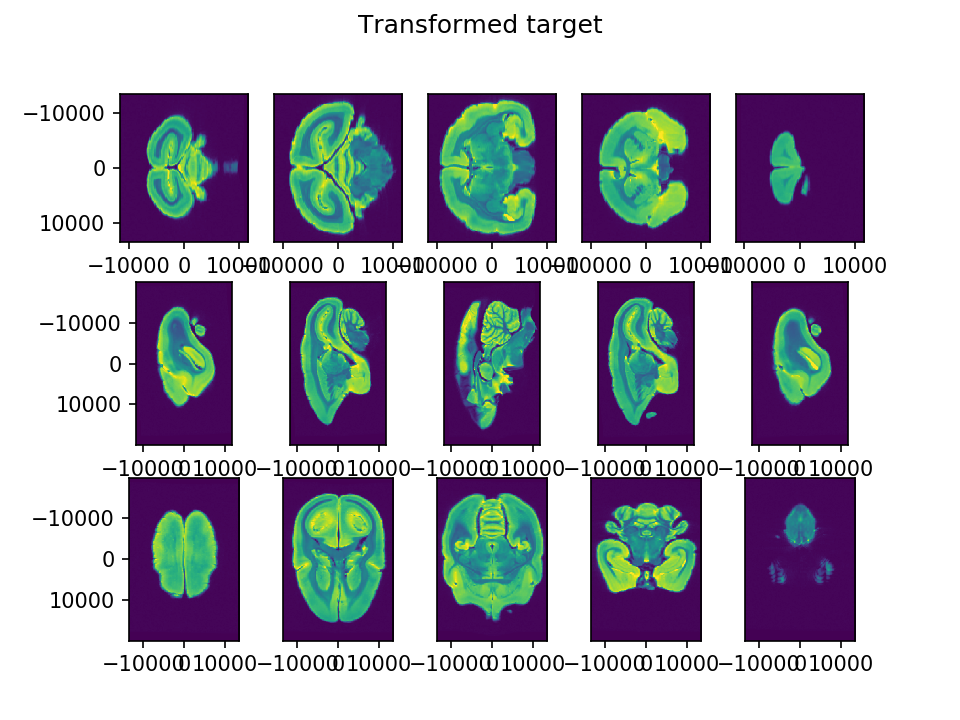

Text(0.5, 0.98, 'Transformed target')

In [57]:
import matplotlib.pyplot as plt
emlddmm.draw(Jt,xI)
plt.gcf().suptitle('Transformed target')

In [58]:
# test it, backward transform
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

<IPython.core.display.Javascript object>


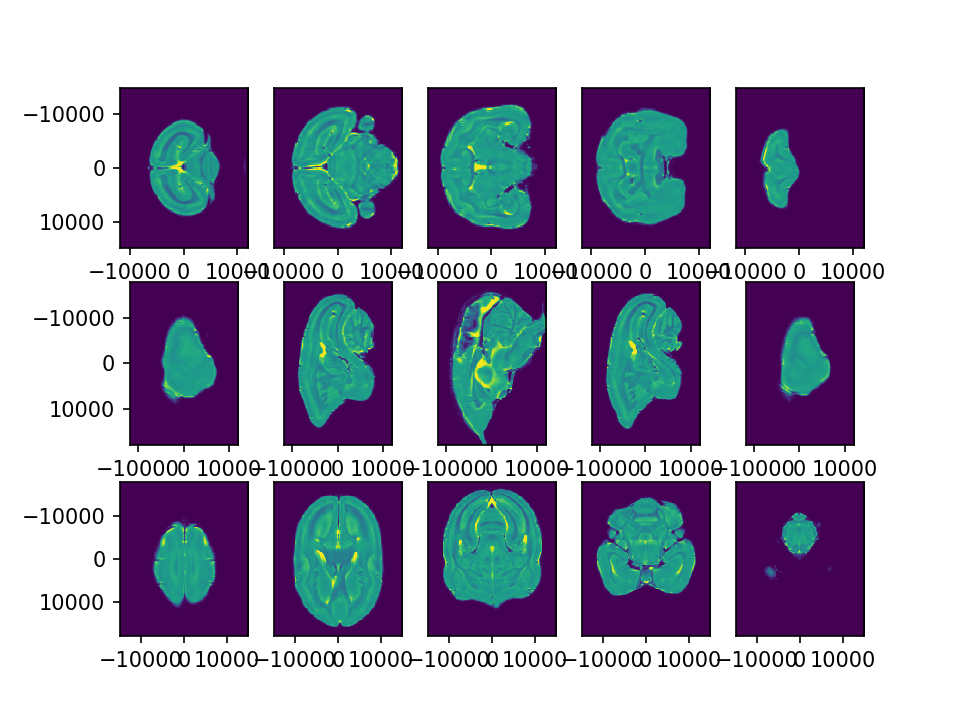

<IPython.core.display.Javascript object>


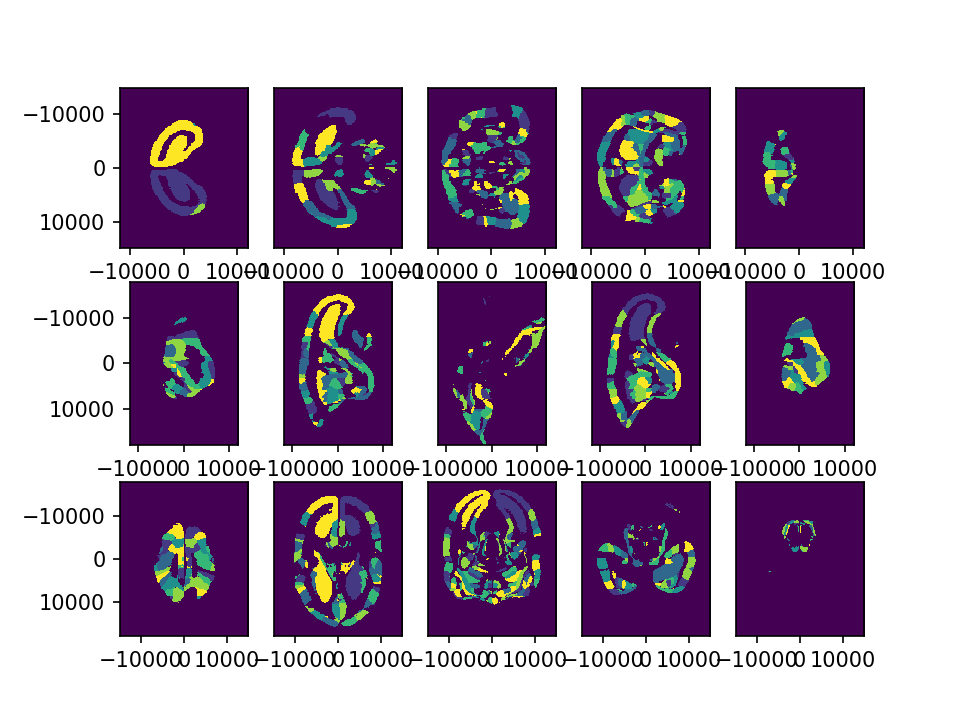

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fd2fbcd9950>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fd2fb9f9c50>]])

In [59]:
emlddmm.draw(It,xJ)
emlddmm.draw(St%7,xJ)

In [60]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [73]:
# write out
imp.reload(emlddmm)
ext = output_image_format
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')
emlddmm.write_data(os.path.join(target_output_dir,'atlas_seg_to_target'+ext),xI,St,'atlas_seg_to_target')

Found extension .nii
Found extension .nii
Found extension .nii


/mnt/data/csh_data/emlddmm/emlddmm.py:1316: UserWarning: Writing image in nii fomat, no title or names saved
  warnings.warn('Writing image in nii fomat, no title or names saved')


In [75]:
# check my output segmentations
np.unique(S)

array([    0,    40,   553,   808,  1280,  1281,  1537,  1792,  1793,
        1832,  1833,  2089,  2305,  2344,  2345,  2561,  2817,  3369,
        3586,  3841,  3880,  3881,  4353,  4609,  4610,  5376,  5415,
        5416,  5672,  5889,  5927,  5928,  6144,  6145,  6146,  6440,
        6656,  6657,  6658,  6696,  6912,  6952,  7168,  7424,  7680,
        7721,  7936,  7938,  7976,  8192,  8448,  8488,  8704,  8744,
        8745,  8960,  9216,  9218,  9472,  9511,  9728,  9984, 10024,
       10240, 10279, 10280, 10281, 10496, 10498, 10752, 10753, 10791,
       10792, 10793, 11008, 11047, 11264, 11266, 11303, 11520, 11522,
       11559, 11776, 11778, 11815, 12032, 12033, 12071, 12073, 12288,
       12289, 12327, 12544, 12545, 12546, 12583, 12800, 12802, 12839,
       13056, 13058, 13095, 13312, 13313, 13314, 13351, 13353, 13568,
       13570, 13607, 13824, 13863, 14080, 14081, 14119, 14336, 14375,
       14592, 14631, 14633, 14848, 14887, 14888, 15104, 15143, 15360,
       15361, 15399,

In [76]:
np.unique(St)

array([    0,    40,   553,   808,  1280,  1281,  1537,  1792,  1793,
        1832,  1833,  2089,  2305,  2344,  2345,  2561,  2817,  3369,
        3586,  3841,  3880,  3881,  4353,  4609,  5376,  5415,  5416,
        5672,  5889,  5927,  5928,  6144,  6145,  6146,  6440,  6656,
        6657,  6658,  6696,  6912,  6952,  7168,  7424,  7680,  7721,
        7936,  7938,  7976,  8192,  8448,  8488,  8704,  8744,  8960,
        9216,  9218,  9472,  9511,  9728,  9984, 10024, 10240, 10279,
       10280, 10281, 10496, 10498, 10752, 10753, 10791, 10792, 10793,
       11008, 11047, 11264, 11266, 11303, 11520, 11522, 11559, 11776,
       11778, 11815, 12032, 12033, 12071, 12073, 12288, 12289, 12327,
       12544, 12545, 12546, 12583, 12800, 12802, 12839, 13056, 13058,
       13095, 13312, 13313, 13314, 13351, 13353, 13568, 13570, 13607,
       13824, 13863, 14080, 14081, 14119, 14336, 14375, 14592, 14631,
       14633, 14848, 14887, 14888, 15104, 15143, 15360, 15361, 15399,
       15401, 15616,